In [142]:
import numpy as np 
import pandas as pd 
import scipy.io
import matplotlib.pyplot as plt
import os
from scipy import signal
from scipy.fft import fft, fftshift
from mne import create_info, EpochsArray
from mne.preprocessing import ICA
from sklearn.svm import SVC
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Accuracy
from sklearn.preprocessing import OneHotEncoder

import warnings
from scipy.signal import butter, iirnotch, filtfilt
warnings.filterwarnings("ignore")

## 1. Data processing

In [143]:
folder_path = r"C:\Users\Daniel\OneDrive - VNU-HCMUS\Desktop\Pattern-Recognition\data\EEG Data"
file_paths = []

for dirname, _, filenames in os.walk(folder_path):
    for filename in filenames:
        file_paths.append(os.path.join(dirname, filename))

file_paths

['C:\\Users\\Daniel\\OneDrive - VNU-HCMUS\\Desktop\\Pattern-Recognition\\data\\EEG Data\\eeg_record1.mat',
 'C:\\Users\\Daniel\\OneDrive - VNU-HCMUS\\Desktop\\Pattern-Recognition\\data\\EEG Data\\eeg_record10.mat',
 'C:\\Users\\Daniel\\OneDrive - VNU-HCMUS\\Desktop\\Pattern-Recognition\\data\\EEG Data\\eeg_record11.mat',
 'C:\\Users\\Daniel\\OneDrive - VNU-HCMUS\\Desktop\\Pattern-Recognition\\data\\EEG Data\\eeg_record12.mat',
 'C:\\Users\\Daniel\\OneDrive - VNU-HCMUS\\Desktop\\Pattern-Recognition\\data\\EEG Data\\eeg_record13.mat',
 'C:\\Users\\Daniel\\OneDrive - VNU-HCMUS\\Desktop\\Pattern-Recognition\\data\\EEG Data\\eeg_record14.mat',
 'C:\\Users\\Daniel\\OneDrive - VNU-HCMUS\\Desktop\\Pattern-Recognition\\data\\EEG Data\\eeg_record15.mat',
 'C:\\Users\\Daniel\\OneDrive - VNU-HCMUS\\Desktop\\Pattern-Recognition\\data\\EEG Data\\eeg_record16.mat',
 'C:\\Users\\Daniel\\OneDrive - VNU-HCMUS\\Desktop\\Pattern-Recognition\\data\\EEG Data\\eeg_record17.mat',
 'C:\\Users\\Daniel\\OneDrive

In [144]:
def load_subject_data(folder_path, subjects, useful_channels):
    """
    Hàm đọc dữ liệu từ các file .mat cho từng đối tượng và lưu toàn bộ dữ liệu mà không chia theo trạng thái.
    
    Parameters:
        folder_path (str): Đường dẫn đến thư mục chứa các file .mat.
        subjects (dict): Dictionary chứa thông tin thí nghiệm của từng người.
        useful_channels (array-like): Danh sách các kênh dữ liệu cần trích xuất.

    Returns:
        dict: Dictionary chứa dữ liệu cho từng đối tượng với các lần thí nghiệm.
    """
    all_subject_data = {}  # Dictionary để lưu dữ liệu toàn bộ các đối tượng

    for subject_name, trials in subjects.items():
        subject_data = {}  # Dictionary lưu dữ liệu từng lần thí nghiệm của đối tượng
        for trial_name, file_name in trials.items():
            file_path = os.path.join(folder_path, file_name + '.mat')
            if os.path.exists(file_path):  # Kiểm tra file có tồn tại
                mat = scipy.io.loadmat(file_path)
                data = mat['o']['data'][0, 0]
                
                # Trích xuất dữ liệu các kênh cần thiết
                subject_data[trial_name] = data[:, useful_channels].copy()
            else:
                print(f"File {file_name} không tồn tại.")
        
        # Lưu dữ liệu của đối tượng vào dictionary chính
        all_subject_data[subject_name] = subject_data

    return all_subject_data

def create_subject_objects(*subjects):
    """
    Tạo các đối tượng từ tên file EEG ứng với từng ngày thí nghiệm.

    Parameters:
        *subjects (dict): Các dictionary chứa tên file của từng người.

    Returns:
        dict: Một dictionary chứa thông tin các lần thí nghiệm của từng người.
    """
    all_subjects = {}
    for i, files in enumerate(subjects, start=1):
        subject_data = {}
        for day, file_name in files.items():
            subject_data[day] = file_name
        all_subjects[f"Subject_{i}"] = subject_data
    return all_subjects


# Dữ liệu của các đối tượng
subj1_files = {'Day_1': 'eeg_record3', 'Day_2': 'eeg_record4', 'Day_3': 'eeg_record5', 
               'Day_4': 'eeg_record6', 'Day_5': 'eeg_record7'}
subj2_files = {'Day_1': 'eeg_record10', 'Day_2': 'eeg_record11', 'Day_3': 'eeg_record12', 
               'Day_4': 'eeg_record13', 'Day_5': 'eeg_record14'}
subj3_files = {'Day_1': 'eeg_record17', 'Day_2': 'eeg_record18', 'Day_3': 'eeg_record19', 
               'Day_4': 'eeg_record20', 'Day_5': 'eeg_record21'}
subj4_files = {'Day_1': 'eeg_record24', 'Day_2': 'eeg_record25', 'Day_3': 'eeg_record26', 
               'Day_4': 'eeg_record27', 'Day_5': 'eeg_record28'}
subj5_files = {'Day_1': 'eeg_record31', 'Day_2': 'eeg_record32', 'Day_3': 'eeg_record33', 
               'Day_4': 'eeg_record34'}

# Tạo các đối tượng
subjects = create_subject_objects(subj1_files, subj2_files, subj3_files, subj4_files, subj5_files)

# Danh sách các kênh cần trích xuất
useful_channels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]) + 3

# Gọi hàm load dữ liệu
all_subject_data = load_subject_data(folder_path, subjects, useful_channels)

# Kiểm tra dữ liệu
for subject, trials in all_subject_data.items():
    print(f"{subject}:")
    for trial, data in trials.items():
        print(f"  {trial}: {data.shape}")


Subject_1:
  Day_1: (357224, 14)
  Day_2: (380344, 14)
  Day_3: (351204, 14)
  Day_4: (288752, 14)
  Day_5: (398816, 14)
Subject_2:
  Day_1: (381340, 14)
  Day_2: (391624, 14)
  Day_3: (356728, 14)
  Day_4: (373304, 14)
  Day_5: (345164, 14)
Subject_3:
  Day_1: (443972, 14)
  Day_2: (361840, 14)
  Day_3: (333236, 14)
  Day_4: (396812, 14)
  Day_5: (336280, 14)
Subject_4:
  Day_1: (360928, 14)
  Day_2: (415164, 14)
  Day_3: (363232, 14)
  Day_4: (347548, 14)
  Day_5: (214540, 14)
Subject_5:
  Day_1: (428848, 14)
  Day_2: (483732, 14)
  Day_3: (483376, 14)
  Day_4: (408976, 14)


In [145]:
mat = scipy.io.loadmat(file_paths[1])
data = mat['o']['data'][0,0]

column_names = [
    'AF3', 'F7', 'F3', 'FC5','T7', 'P7', 'O1', 'O2', 
    'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'
]
data_1 = pd.DataFrame(all_subject_data['Subject_1']['Day_1'], columns=column_names)

In [146]:
data_1.head()

AF3           F7           F3          FC5          T7  \
0  4440.512821  3804.102564  5210.769231  3829.230769  4030.25641   
1  4440.512821  3796.410256  5205.641026  3827.179487  4030.25641   
2  4440.512821  3798.974359  5207.179487  3827.692308  4030.25641   
3  4440.512821  3801.538462  5210.256410  3830.769231  4030.25641   
4  4440.512821  3799.487179  5210.256410  3831.794872  4030.25641   

            P7           O1           O2           P8           T8  \
0  4490.769231  3862.051282  3511.794872  4321.025641  4304.615385   
1  4489.230769  3858.461538  3505.128205  4311.794872  4304.615385   
2  4489.230769  3865.128205  3511.794872  4313.846154  4304.615385   
3  4490.256410  3866.153846  3511.282051  4315.897436  4304.615385   
4  4490.256410  3865.641026  3506.153846  4311.282051  4304.615385   

           FC6           F4           F8          AF4  
0  4141.025641  4282.564103  4333.846154  4024.102564  
1  4144.615385  4282.564103  4335.384615  4017.948718  
2  4148.717949  4282.564103  4334.871795  4018.974359  
3  4146.666667  4282.564103  4334.358974  4022.051282  
4  4145.641026  4282.564103  4333.846154  4020.512821

In [147]:
data_1.describe()

AF3             F7             F3            FC5  \
count  357224.000000  357224.000000  357224.000000  357224.000000   
mean     4442.861566    3990.083616    5047.800843    3828.546854   
std         1.828374      97.286654      83.943277       3.061663   
min      4396.410256    3429.743590    4668.205128    3712.820513   
25%      4441.538462    3961.025641    5012.307692    3827.179487   
50%      4442.564103    4015.897436    5043.076923    3829.230769   
75%      4444.102564    4045.641026    5071.282051    3830.769231   
max      4476.923077    4393.846154    5614.871795    3901.538462   

                  T7             P7             O1             O2  \
count  357224.000000  357224.000000  357224.000000  357224.000000   
mean     4034.156173    4317.821706    4273.852562    4025.072245   
std         1.643322      77.132528     141.173615     147.484125   
min      4011.282051    3987.692308    3452.307692    3122.564103   
25%      4033.846154    4281.538462    4237.948718    3993.846154   
50%      4034.358974    4314.871795    4309.743590    4068.205128   
75%      4034.871795    4342.051282    4353.333333    4109.230769   
max      4073.846154    4845.128205    4704.102564    4465.128205   

                  P8             T8            FC6             F4  \
count  357224.000000  357224.000000  357224.000000  357224.000000   
mean     4169.952711    4311.323122    4145.774772    4282.261852   
std        77.444571       3.241797       4.185887       0.839869   
min      3547.179487    4296.410256    3804.615385    4264.615385   
25%      4137.948718    4308.717949    4144.615385    4282.051282   
50%      4169.743590    4311.794872    4145.641026    4282.051282   
75%      4200.000000    4313.333333    4147.179487    4282.564103   
max      4662.564103    4324.102564    4373.333333    4299.487179   

                  F8            AF4  
count  357224.000000  357224.000000  
mean     4335.027811    4121.306844  
std         0.829719      57.871808  
min      4316.410256    3785.641026  
25%      4334.358974    4093.333333  
50%      4334.871795    4122.051282  
75%      4335.897436    4150.769231  
max      4364.102564    4478.974359

In [148]:
data_1.shape

(357224, 14)

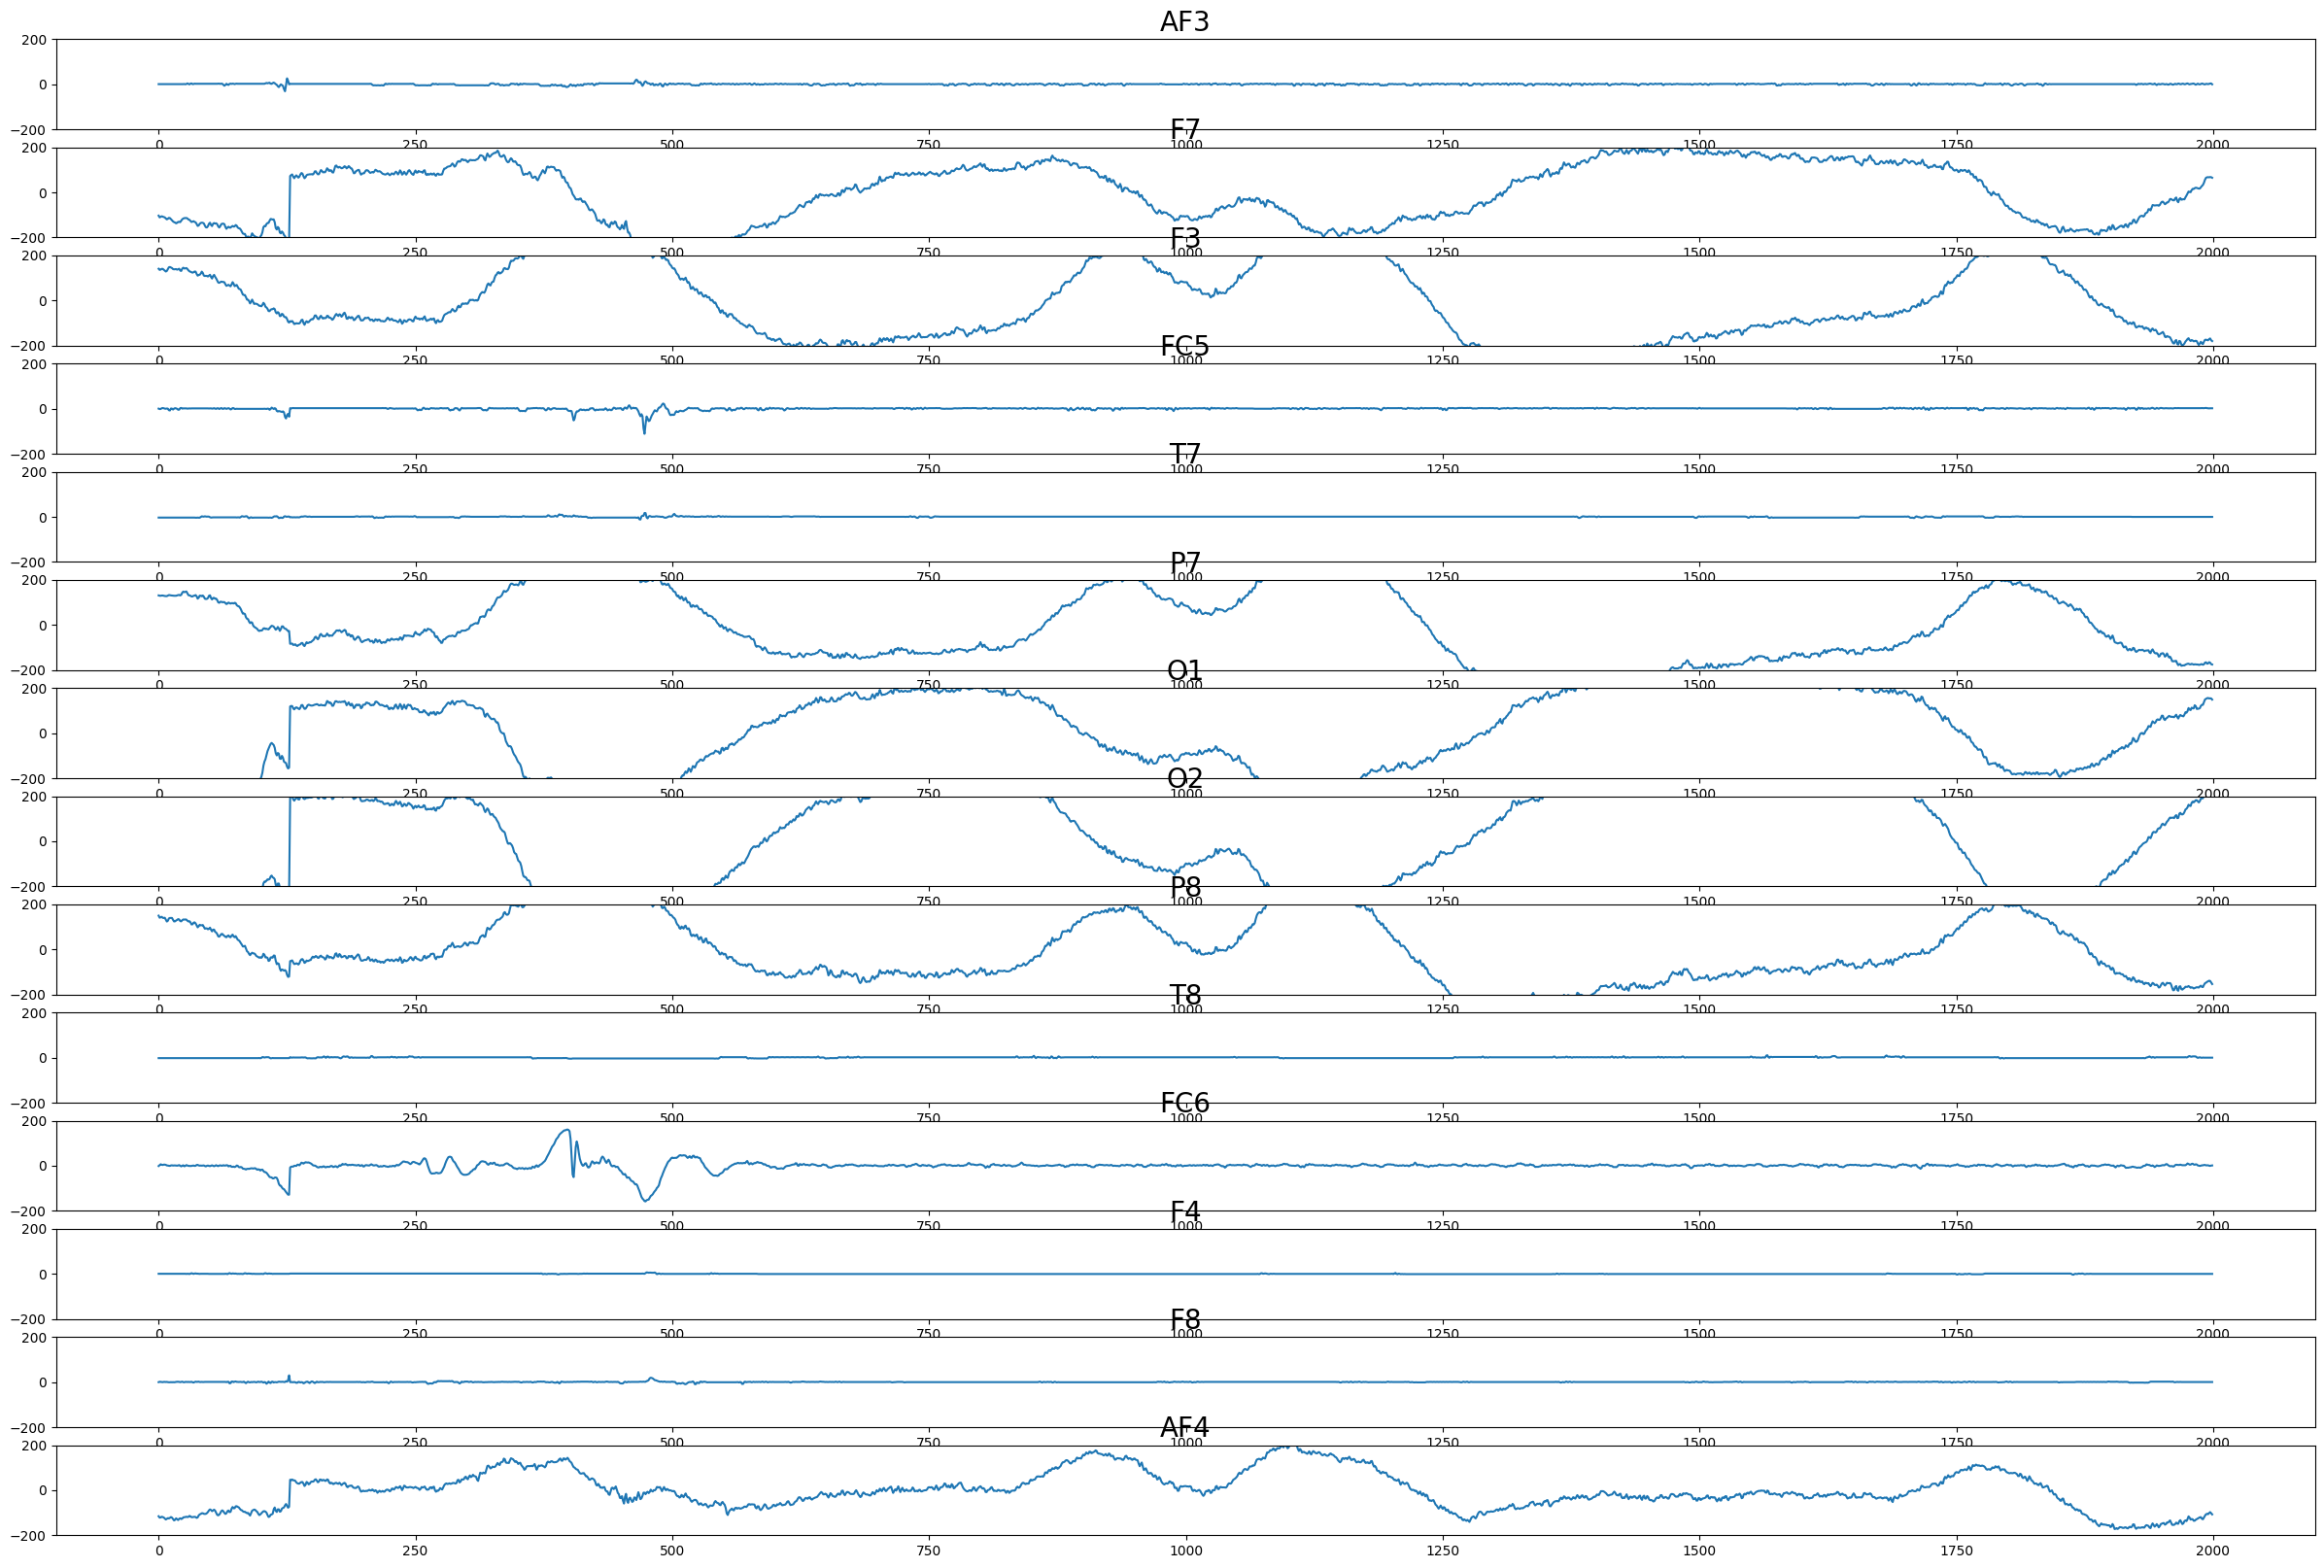

In [149]:
fig, ax = plt.subplots(14,1)
fig.set_figwidth(20)
fig.set_figheight(50)
fig.set_size_inches(30, 20)
for i in range(14):
    data_ave = data_1.iloc[:2000, i] - np.mean(data_1.iloc[:2000, i])
    ax[i].plot(data_ave)
    ax[i].set_title(data_1.columns[i], fontsize=20)
    ax[i].set_ylim(-200, 200)

Môi tập dữ liệu là một bản ghi lại tín hiệu sóng não thông qua quá trình thử nghiệm lái tàu mô phỏng trên máy tính có tên là "Microsoft Train Simulator". Với 5 người tham gia, mỗi file sẽ kéo dài trong khoảng 35-55 phút, mỗi người chơi thực hiện 7 lần thử nghiệm.

Trong 10 phút đầu người chơi duy trì trạng thái tập trung, ở 10 phút tiếp theo thì người chơi sẽ vào trạng thái không tập trung, và thời gian còn lại sẽ rơi vào trạng thái buồn ngủ.

Trong bản ghi tác giả có nói 2 bản ghi đầu của mỗi đối tượng sẽ để làm quen nên ta sẽ chỉ lấy 5 bản ghi cuối cùng của mỗi người tham gia, và người thứ 5 sẽ không được ghi lại ở bản ghi thứ 7

In [150]:
# def load_data(folder_path, useful_file_index, marker, useful_channels):
#     focus = {}
#     unfocus = {}
#     drowsy = {}

#     for dirname, _, filenames in os.walk(folder_path):
#         for filename in filenames:
#             file_index = int(filename.split('d')[1].split('.')[0])
#             if file_index in useful_file_index:
#                 # Load file .mat
#                 mat = scipy.io.loadmat(os.path.join(dirname, filename))
#                 data = mat['o']['data'][0, 0]
#                 trail_name = filename.split('.')[0]
                
#                 # Trích xuất dữ liệu cho từng trạng thái
#                 focus[trail_name] = data[0:marker, useful_channels].copy()
#                 unfocus[trail_name] = data[marker:2*marker, useful_channels].copy()
#                 drowsy[trail_name] = data[2*marker:3*marker, useful_channels].copy()

#     return {"focus": focus, "unfocus": unfocus, "drowsy": drowsy}

# def extract_trail_names(folder_path, useful_file_index):
#     trail_names = []
#     for dirname, _, filenames in os.walk(folder_path):
#         for filename in filenames:
#             file_index = int(filename.split('d')[1].split('.')[0])
#             if file_index in useful_file_index:
#                 trail_names.append(filename.split('.')[0])
#     return trail_names

In [151]:
# useful_file_index = [3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 31, 32, 33, 34]
# marker = 128 * 60 * 10
# useful_channels = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]) + 3

# data = load_data(folder_path, useful_file_index, marker, useful_channels)
# focus_data = data["focus"]
# unfocus_data = data["unfocus"]
# drowsy_data = data["drowsy"]

# trail_names = extract_trail_names(folder_path, useful_file_index)
# print("Trail Names:", trail_names)

In [152]:
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch

def combined_filter(data, fs=128):
    """
    Áp dụng bộ lọc band-pass từ 0.5Hz đến 40Hz và bộ lọc Notch tại 50Hz.
    
    Parameters:
        data (ndarray): Dữ liệu EEG cần lọc.
        fs (int): Tần số lấy mẫu (Hz), mặc định là 128.
    
    Returns:
        ndarray: Dữ liệu đã được lọc.
    """
    nyquist = fs / 2
    low = 0.5 / nyquist
    high = 40 / nyquist
    b_band, a_band = butter(6, [low, high], btype='band')
    
    # Thiết kế bộ lọc Notch tại 50Hz
    notch_freq = 50  # tần số nguồn điện
    quality_factor = 10  # độ rộng của bộ lọc
    b_notch, a_notch = iirnotch(notch_freq, quality_factor, fs)
    
    # Áp dụng bộ lọc band-pass
    bandpass_filtered = filtfilt(b_band, a_band, data)
    
    # Áp dụng bộ lọc Notch
    filtered_signal = filtfilt(b_notch, a_notch, bandpass_filtered)
    
    return filtered_signal

def filter_subject_data(subject_data, fs=128):
    """
    Lọc dữ liệu cho tất cả các đối tượng và các ngày thí nghiệm.

    Parameters:
        subject_data (dict): Dữ liệu của các đối tượng và các lần thí nghiệm.
        fs (int): Tần số lấy mẫu (Hz), mặc định là 128.

    Returns:
        dict: Dữ liệu đã lọc cho các đối tượng.
    """
    filtered_data = {}

    # Duyệt qua tất cả các đối tượng
    for subject_name, trials in subject_data.items():
        subject_filtered = {}
        
        # Duyệt qua các ngày thí nghiệm của đối tượng
        for trial_name, data in trials.items():
            # Lọc dữ liệu của từng ngày thí nghiệm
            subject_filtered[trial_name] = np.apply_along_axis(combined_filter, axis=0, arr=data, fs=fs)
        
        # Lưu dữ liệu đã lọc của đối tượng
        filtered_data[subject_name] = subject_filtered

    return filtered_data

# Áp dụng lọc dữ liệu cho các đối tượng
filtered_all_subject_data = filter_subject_data(all_subject_data, fs=128)

In [153]:
channel_names = column_names

In [154]:
import matplotlib.pyplot as plt

def analyze_data(all_subject_data, filtered_all_subject_data, num_subjects=2, num_days=1, fs=128):
    """
    Vẽ biểu đồ tín hiệu EEG trước và sau khi lọc cho các đối tượng trong từng ngày thí nghiệm.
    
    Parameters:
    - all_subject_data: Dữ liệu thô của tất cả các đối tượng
    - filtered_all_subject_data: Dữ liệu đã lọc của tất cả các đối tượng
    - num_subjects: Số lượng đối tượng cần phân tích (mặc định là 2)
    - num_days: Số lượng ngày thí nghiệm cần phân tích (mặc định là 1)
    - fs: Tần số lấy mẫu
    """
    subjects = list(all_subject_data.keys())[:num_subjects]  # Lấy một số đối tượng cần phân tích
    
    for subject in subjects:
        subject_data = all_subject_data[subject]
        subject_filtered_data = filtered_all_subject_data[subject]
        
        # Duyệt qua các ngày thí nghiệm
        days = list(subject_data.keys())[:num_days]  # Lấy số ngày cần phân tích
        for day in days:
            raw_data = subject_data[day]
            filtered_data = subject_filtered_data[day]

            # Vẽ biểu đồ tín hiệu gốc
            plt.figure(figsize=(15, 10))
            plt.subplot(2, 1, 1)
            plt.plot(raw_data[:500, :])  # Vẽ 500 mẫu đầu tiên của dữ liệu
            plt.title(f"Raw EEG Data - {subject} - {day}")
            plt.xlabel("Sample")
            plt.ylabel("Amplitude")
            plt.legend(channel_names)
            plt.grid(True)

            # Vẽ biểu đồ tín hiệu đã lọc
            plt.subplot(2, 1, 2)
            plt.plot(filtered_data[:500, :])  # Vẽ 500 mẫu đầu tiên của dữ liệu đã lọc
            plt.title(f"Filtered EEG Data - {subject} - {day}")
            plt.xlabel("Sample")
            plt.ylabel("Amplitude")
            plt.legend(channel_names)
            plt.grid(True)

            plt.tight_layout()
            plt.show()



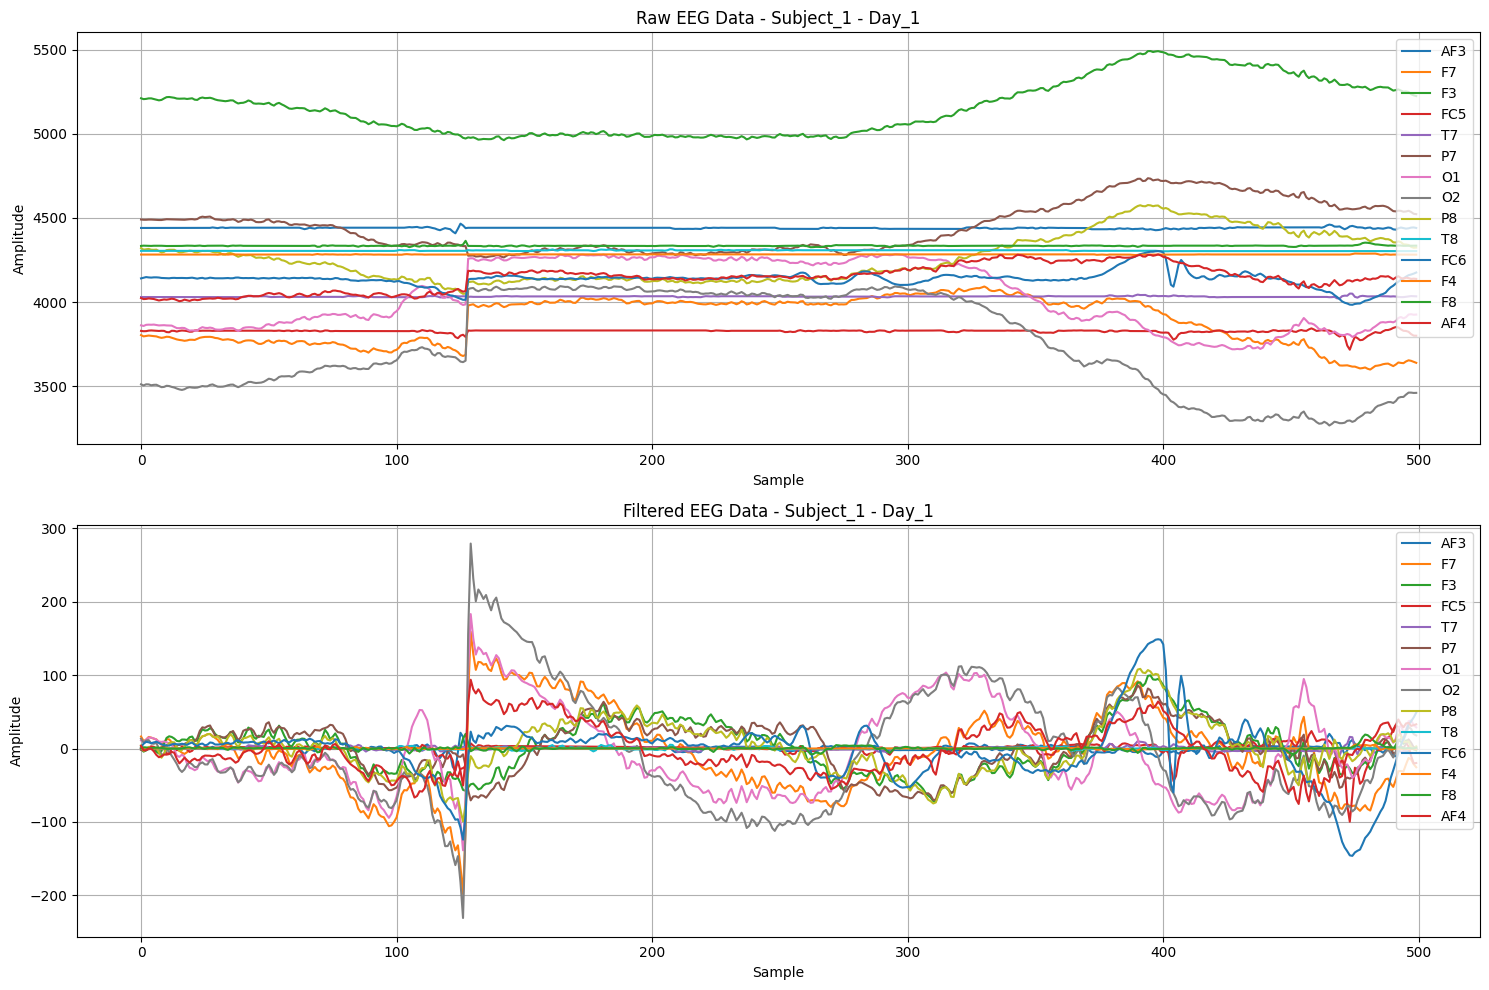

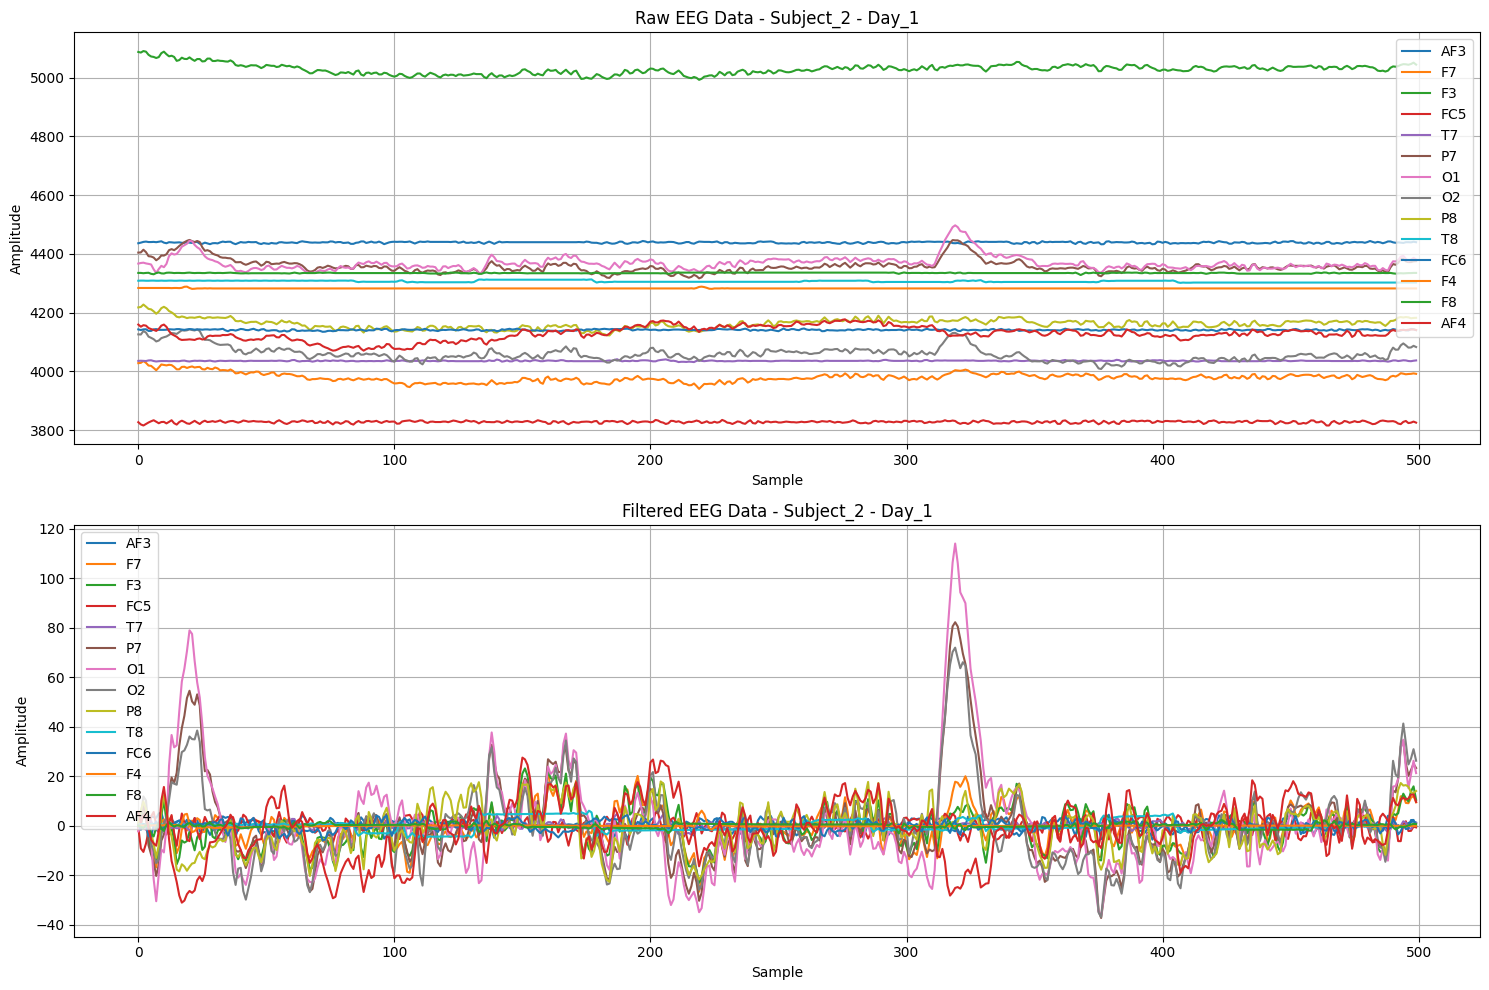

In [155]:
# Áp dụng phân tích và vẽ biểu đồ cho các đối tượng và các ngày thí nghiệm
analyze_data(all_subject_data, filtered_all_subject_data, num_subjects=2, num_days=1, fs=128)

In [164]:
channel_names
#'AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4'

['AF3',
 'F7',
 'F3',
 'FC5',
 'T7',
 'P7',
 'O1',
 'O2',
 'P8',
 'T8',
 'FC6',
 'F4',
 'F8',
 'AF4']

In [156]:
filtered_all_subject_data['Subject_1']['Day_1'].shape

(357224, 14)

In [167]:
import mne
from mne.preprocessing import ICA

def apply_ica(filtered_all_subject_data, channel_names):
    ica_list = {}  # Lưu ICA cho từng đối tượng
    raw_list = {}  # Lưu Raw cho từng đối tượng

    # Duyệt qua từng đối tượng trong all_subject_data
    for subject_name, subject_data in filtered_all_subject_data.items():
        ica_list[subject_name] = []
        raw_list[subject_name] = []

        # Duyệt qua các ngày thí nghiệm của từng đối tượng
        for day, data_one_day in subject_data.items():
            sfreq = 128 
            info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types='eeg')
            filtered_data_mne = data_one_day.T  

            # Tạo đối tượng Raw từ dữ liệu
            raw = mne.io.RawArray(filtered_data_mne, info)

            # Thêm montage(vị tri điện cực chuẩn) vào đối tượng Raw với montage 'standard_1020'
            montage = mne.channels.make_standard_montage('standard_1020')
            raw.set_montage(montage)

            # Áp dụng ICA để tách các thành phần độc lập
            ica = ICA(n_components=14, random_state=42, max_iter='auto')
            ica.fit(raw)
            
            ica_list[subject_name].append(ica)
            raw_list[subject_name].append(raw)

    return ica_list, raw_list

# Giả sử filtered_all_subject_data là dữ liệu đã lọc của tất cả các đối tượng
ica_list, raw_list = apply_ica(filtered_all_subject_data, channel_names)


Creating RawArray with float64 data, n_channels=14, n_times=357224
    Range : 0 ... 357223 =      0.000 ...  2790.805 secs
Ready.
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 2.4s.
Creating RawArray with float64 data, n_channels=14, n_times=380344
    Range : 0 ... 380343 =      0.000 ...  2971.430 secs
Ready.
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 4.0s.
Creating RawArray with float64 data, n_channels=14, n_times=351204
    Range : 0 ... 351203 =      0.000 ...  2743.773 secs
Ready.
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 2.8s.
Creating RawArray with float64 data, n_channels=14, n_times=288752
    Range : 0 ... 288751 =      0.000 ...  2255.867 secs
Ready.
Fitting ICA to data using 14 channels (please be patient, t

In [168]:
raw_list['Subject_1'][2].info

<Info | 8 non-empty values
 bads: []
 ch_names: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4
 chs: 14 EEG
 custom_ref_applied: False
 dig: 17 items (3 Cardinal, 14 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: []
 sfreq: 128.0 Hz
>

In [224]:
raw_list['Subject_1'][2].info

<Info | 8 non-empty values
 bads: []
 ch_names: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4
 chs: 14 EEG
 custom_ref_applied: False
 dig: 17 items (3 Cardinal, 14 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: []
 sfreq: 128.0 Hz
>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


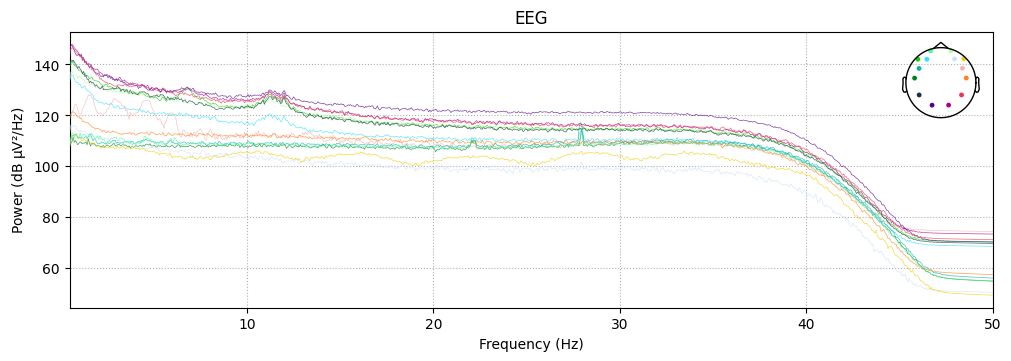

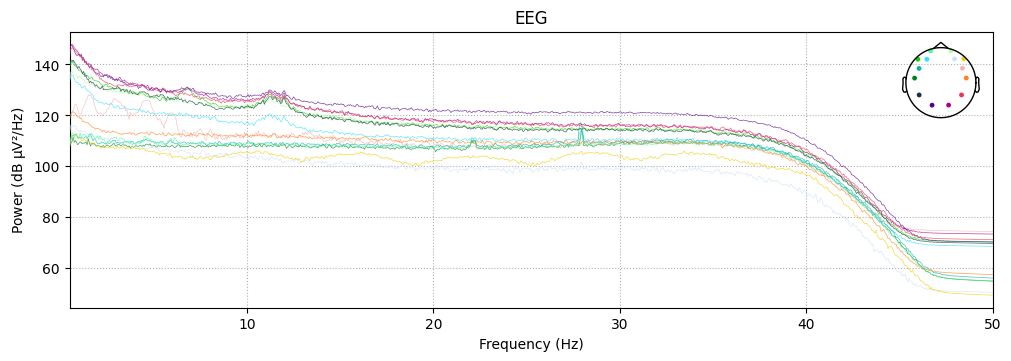

In [227]:
raw_list['Subject_1'][2].plot_psd(fmin=0.5, fmax=50, average=False)

In [221]:
ica_list['Subject_1'][1]

<ICA | raw data decomposition, method: fastica (fit in 29 iterations on 380344 samples), 14 ICA components (14 PCA components available), channel types: eeg, 5 sources marked for exclusion>

In [182]:
def plot_ica_components_and_sources(subject_name, start_day, end_day, ica_list, raw_list):
    """
    Vẽ các thành phần ICA và tín hiệu nguồn cho một đối tượng (subject) cụ thể trong một khoảng thời gian (start_day đến end_day).

    Parameters:
    - subject_name: str, tên của đối tượng cần vẽ.
    - start_day: int, ngày bắt đầu (chỉ số ngày, bắt đầu từ 0).
    - end_day: int, ngày kết thúc (chỉ số ngày, bắt đầu từ 0).
    - ica_list: dict, danh sách các đối tượng ICA theo từng subject.
    - raw_list: dict, danh sách các đối tượng Raw theo từng subject.
    """
    # Kiểm tra xem subject_name có tồn tại trong ica_list và raw_list không
    if subject_name not in ica_list or subject_name not in raw_list:
        print(f"Subject {subject_name} không tồn tại trong danh sách ICA hoặc Raw.")
        return

    # Lặp qua các ngày trong khoảng start_day đến end_day
    for day_idx in range(start_day, end_day + 1):
        ica = ica_list[subject_name][day_idx]
        raw = raw_list[subject_name][day_idx]
        
        print(f"Subject {subject_name}, Day {day_idx + 1}")
        
        # Vẽ tín hiệu nguồn
        ica.plot_sources(raw, start=0, stop=20)
        
        # Vẽ các thành phần ICA
        ica.plot_components(outlines='head')

In [186]:
raw_list['Subject_1'][0]

<RawArray | 14 x 357224 (2790.8 s), ~38.2 MB, data loaded>

Subject Subject_1, Day 1
Creating RawArray with float64 data, n_channels=14, n_times=357224
    Range : 0 ... 357223 =      0.000 ...  2790.805 secs
Ready.


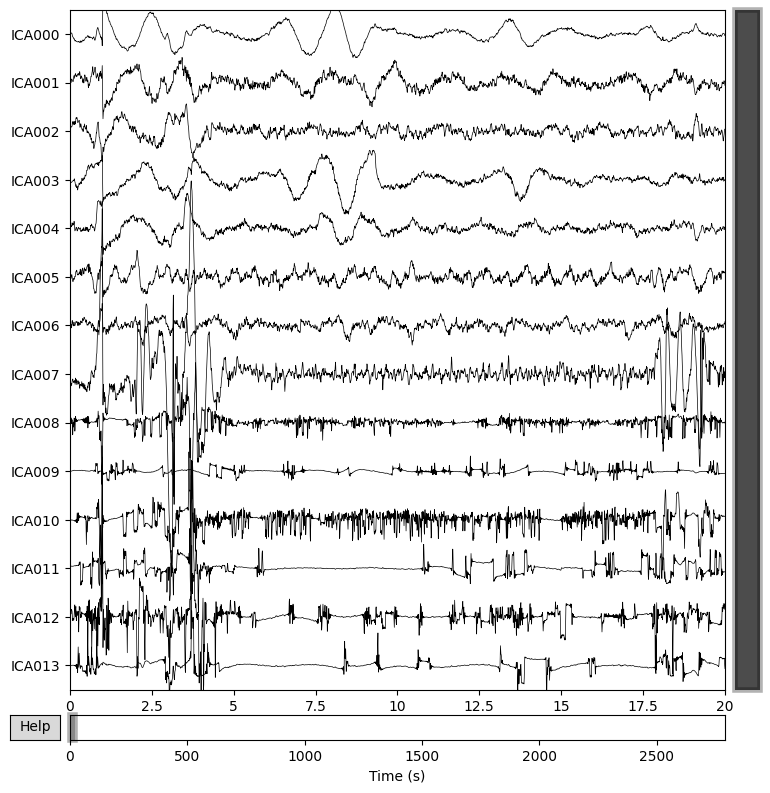

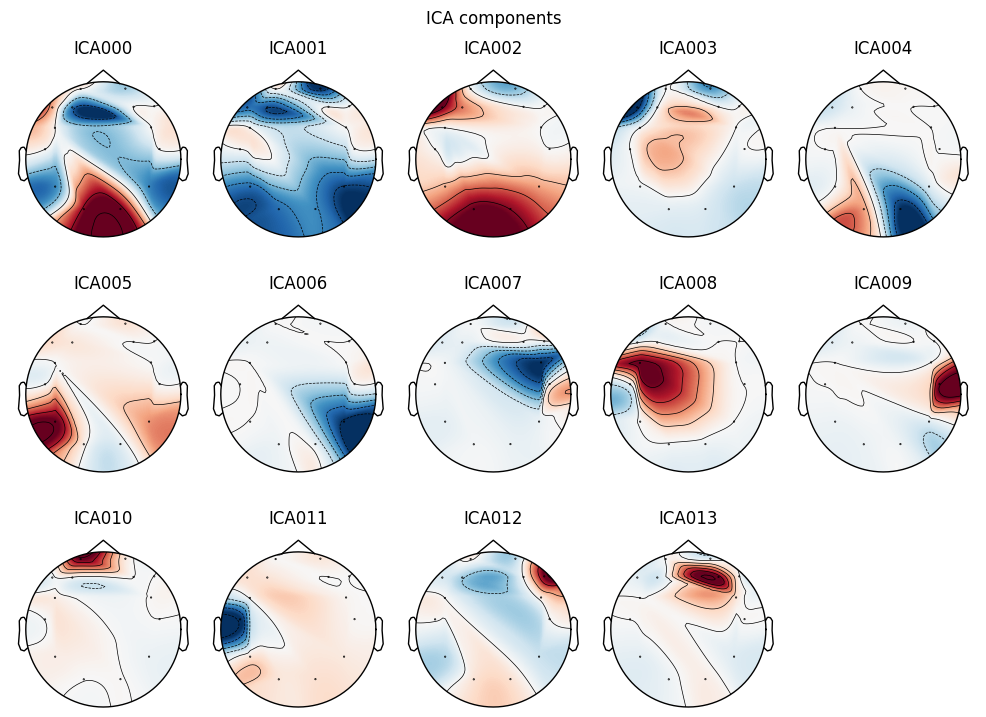

Subject Subject_1, Day 2
Creating RawArray with float64 data, n_channels=14, n_times=380344
    Range : 0 ... 380343 =      0.000 ...  2971.430 secs
Ready.


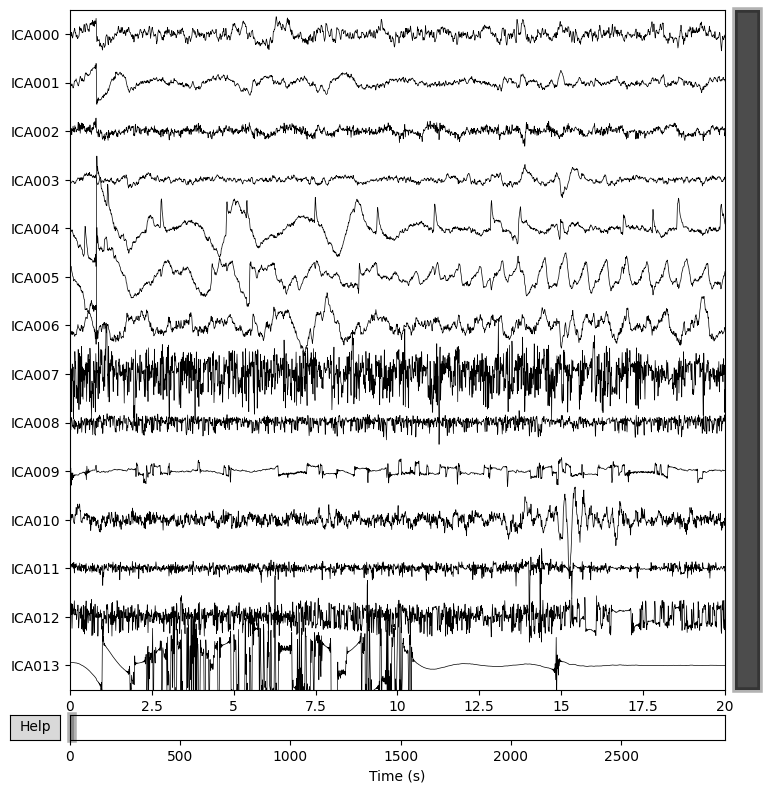

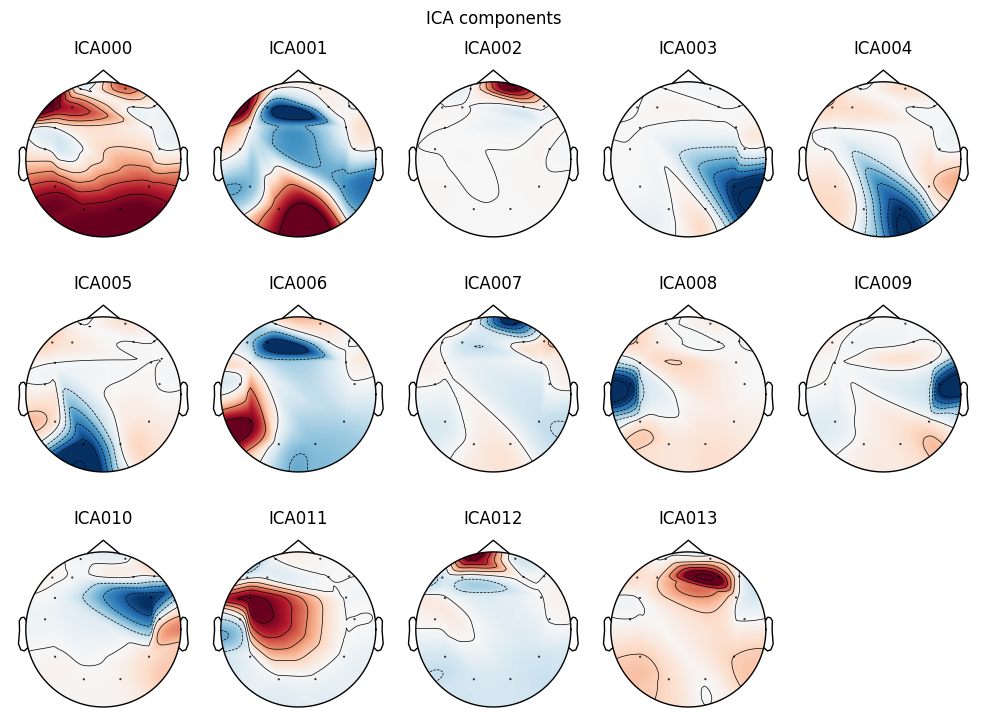

Subject Subject_1, Day 3
Creating RawArray with float64 data, n_channels=14, n_times=351204
    Range : 0 ... 351203 =      0.000 ...  2743.773 secs
Ready.


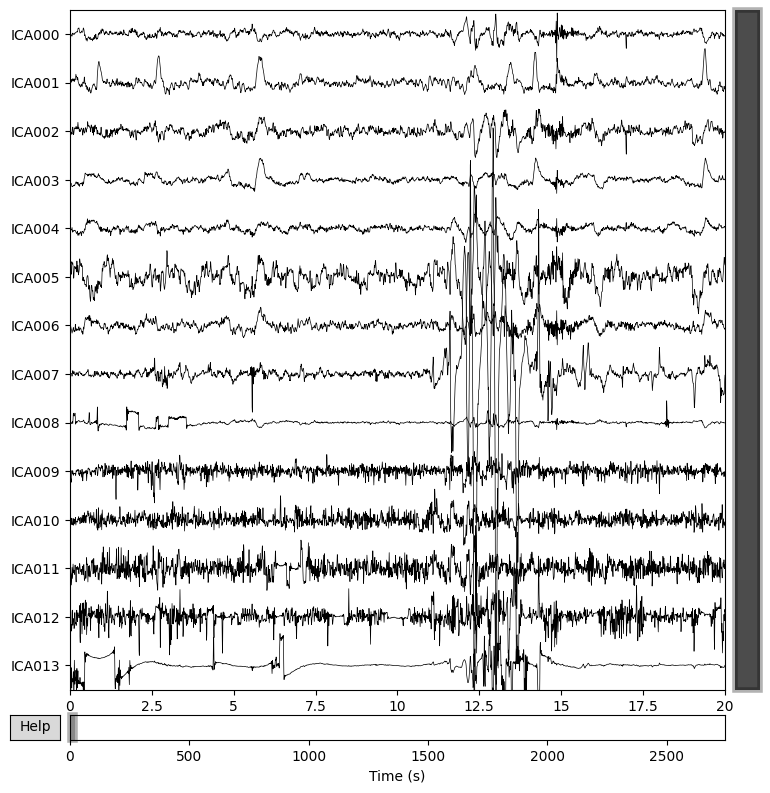

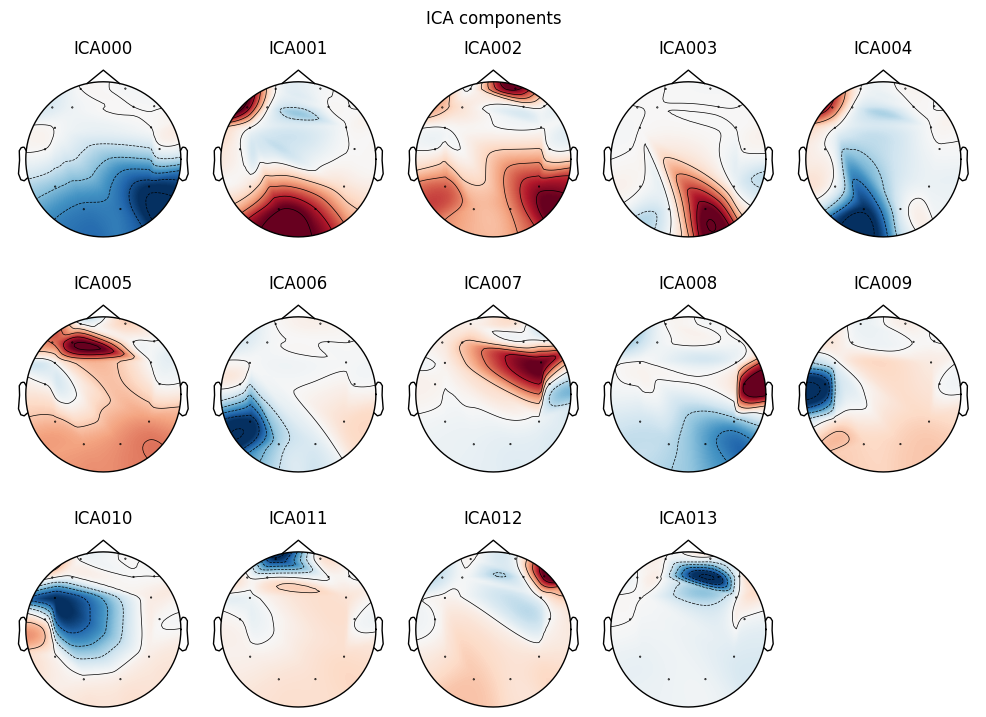

In [183]:
# Vẽ cho Subject_1 từ ngày 1 đến ngày 3
plot_ica_components_and_sources('Subject_1', 0, 2, ica_list, raw_list)

Using EOG channels: AF3, F7, F3, F4, F8, AF4
EOG channel index for this subject is: [ 0  1  2 11 12 13]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel F7 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 14 significant peaks
Number of EOG events detected: 14
Not setting metadata
14 matching events found
No baseline correction applied
Using data from preloaded Raw for 14 events and 129 original time points ...
0 bad epochs dropp

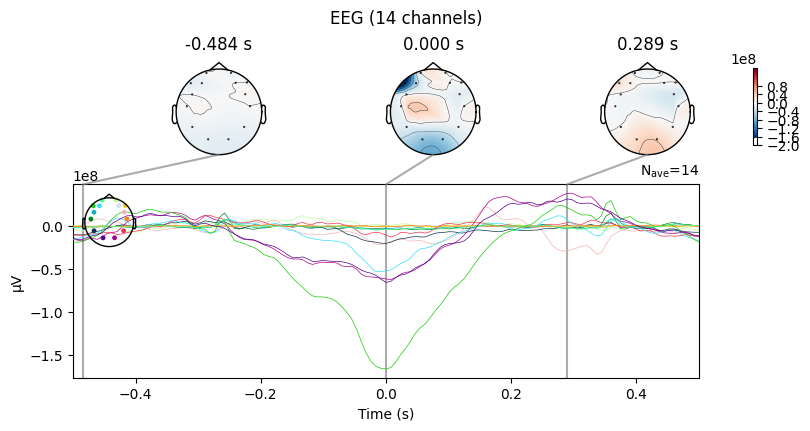

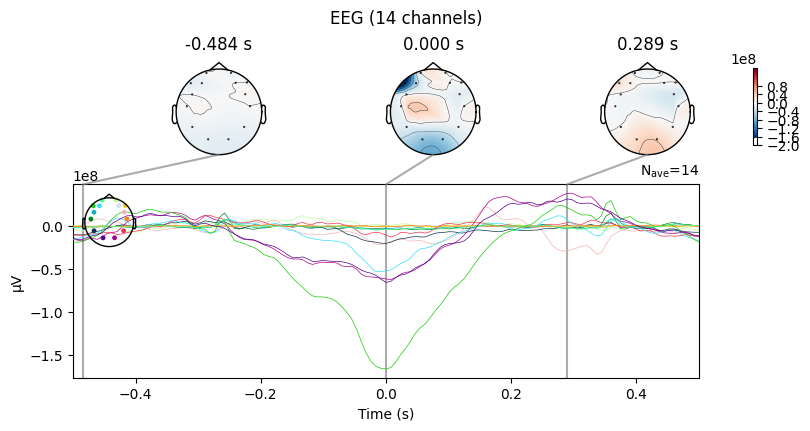

In [276]:
from mne.preprocessing import create_eog_epochs

eye_channels = ['AF3', 'F7', 'F3', 'F4', 'F8', 'AF4']  # Kênh EOG
heart_channels = ['FC5', 'FC6']  # Kênh ECG
# Specify the subject and day
subject = 'Subject_1'
day = 2

# Get the raw object
raw = raw_list[subject][day]

# Create EOG epochs and plot
eog_evoked = create_eog_epochs(raw, ch_name=eye_channels).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

In [ ]:
import matplotlib.pyplot as plt



def detect_noisy_components(ica_list, raw_list, threshold_eog=3.0, threshold_ecg=0.3):
    """
    Phát hiện các thành phần nhiễu EOG và ECG trong dữ liệu Raw bằng cách áp dụng ICA.

    Parameters:
    - ica_list: dict, danh sách các đối tượng ICA theo từng subject.
    - raw_list: dict, danh sách các đối tượng Raw theo từng subject.
    - threshold_eog: float, ngưỡng để phát hiện nhiễu EOG (mặc định là 3.0).
    - threshold_ecg: float, ngưỡng để phát hiện nhiễu ECG (mặc định là 0.3).

    Returns:
    - exclude_components_dict: dict, danh sách các thành phần bị loại bỏ tự động.
    """
    exclude_components_dict = {}

    for subject, ica_subject in ica_list.items():
        exclude_components_dict[subject] = {}
        for day_idx, ica in enumerate(ica_subject):
            raw = raw_list[subject][day_idx]

            # Tự động tìm các thành phần liên quan đến EOG
            eog_indices, eog_scores = ica.find_bads_eog(raw, threshold=threshold_eog, ch_name=eye_channels)
            print(f"Subject {subject}, Day {day_idx + 1} - EOG components: {eog_indices}")

            # Tự động tìm các thành phần liên quan đến ECG (dựa trên heart_channels)
            ecg_indices = []
            for ecg_channel in heart_channels:
                # Duyệt qua từng kênh ECG và tìm các thành phần ECG
                idx, scores = ica.find_bads_ecg(raw, threshold=threshold_ecg, ch_name=ecg_channel)
                ecg_indices.extend(idx)
                print(f"Subject {subject}, Day {day_idx + 1} - ECG component for {ecg_channel}: {idx}")

            # Hợp nhất các thành phần nhiễu từ EOG và ECG
            exclude_components = list(set(eog_indices + ecg_indices))
            print(f"Subject {subject}, Day {day_idx + 1} - Excluded components: {exclude_components}")

            # Lưu vào dictionary để loại bỏ các thành phần nhiễu trong ICA
            exclude_components_dict[subject][day_idx] = exclude_components

            # Đánh dấu các thành phần bị loại bỏ
            ica.exclude = exclude_components

    return exclude_components_dict


In [199]:
# Detect noisy components
exclude_components_dict = detect_noisy_components(ica_list, raw_list)

Using EOG channels: AF3, AF4, F7, F8, F3, F4
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff f

In [202]:
exclude_components_dict['Subject_1'].values()

dict_values([[1, 7, 10, 12, 13], [0, 2, 10, 12, 13], [2, 5, 7, 11, 12, 13], [0, 11, 13, 6], [2, 8, 9, 10, 12, 13]])

In [203]:
def apply_ica_and_clean_data(ica_list, raw_list, exclude_components_dict):
    """
    Áp dụng ICA và loại bỏ các thành phần nhiễu EOG, ECG từ dữ liệu.

    Parameters:
    - ica_list: dict, danh sách các đối tượng ICA theo từng subject.
    - raw_list: dict, danh sách các đối tượng Raw theo từng subject.
    - exclude_components_dict: dict, các thành phần nhiễu cần loại bỏ.

    Returns:
    - cleaned_raw_list: dict, danh sách các đối tượng Raw sau khi đã loại bỏ nhiễu.
    """
    cleaned_raw_list = {}

    for subject, ica_subject in ica_list.items():
        cleaned_raw_list[subject] = []
        for day_idx, ica in enumerate(ica_subject):
            raw = raw_list[subject][day_idx]

            # Lấy danh sách các thành phần cần loại bỏ từ exclude_components_dict
            exclude_components = exclude_components_dict[subject].get(day_idx, [])
            
            # Đánh dấu các thành phần nhiễu để loại bỏ
            ica.exclude = exclude_components

            # Áp dụng ICA để loại bỏ các thành phần nhiễu
            raw_cleaned = ica.apply(raw.copy())  # Tạo ra dữ liệu sạch sau khi loại bỏ nhiễu

            cleaned_raw_list[subject].append(raw_cleaned)

    return cleaned_raw_list


In [233]:
cleaned_raw_list = apply_ica_and_clean_data(ica_list, raw_list, exclude_components_dict)

Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 5 ICA components
    Projecting back using 14 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 5 ICA components
    Projecting back using 14 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 6 ICA components
    Projecting back using 14 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 4 ICA components
    Projecting back using 14 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 6 ICA components
    Projecting back using 14 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 5 ICA components
    Projecting back using 14 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing o

In [ ]:
def store_cleaned_data_as_filtered_dict(cleaned_raw_list):
    """
    Lưu dữ liệu đã làm sạch vào dict mới với cấu trúc filtered_all_subject_data.

    Parameters:
    - cleaned_raw_list: dict, danh sách các đối tượng Raw sau khi đã loại bỏ nhiễu.

    Returns:
    - filtered_all_subject_data: dict, cấu trúc dữ liệu sạch theo subject và ngày.
    """
    eeg_data_ica_filterd = {}

    for subject, raw_subject in cleaned_raw_list.items():
        eeg_data_ica_filterd[subject] = {}

        for day_idx, _ in enumerate(raw_subject):
            day_key = f"Day_{day_idx + 1}" 
            data_array = raw_data.get_data().T
            eeg_data_ica_filterd[subject][day_key] = data_array

    return eeg_data_ica_filterd

# Lưu dữ liệu sạch vào dict mới
eeg_data_ica_filterd = store_cleaned_data_as_filtered_dict(cleaned_raw_list)


In [252]:
eeg_data_ica_filterd['Subject_1']['Day_1'].shape

(357224, 14)

In [302]:
# Định nghĩa lại hàm split_data_by_state để áp dụng cho eeg_data_ica_filtered
def split_data_by_state(subject_data, sfreq=128, focus_duration=10, unfocus_duration=10):
    focus_samples = focus_duration * 60 * sfreq
    
    split_data = {'focus': {}, 'unfocus': {}, 'drowsy': {}}
    
    for subject, days_data in subject_data.items():
        focus_data_list = []
        unfocus_data_list = []
        drowsy_data_list = []
        
        for day, data in days_data.items():
            focus_data = data[:focus_samples]
            unfocus_data = data[focus_samples:focus_samples*2]
            drowsy_data = data[focus_samples*2:focus_samples*3]
            
            focus_data_list.append(focus_data)
            unfocus_data_list.append(unfocus_data)
            drowsy_data_list.append(drowsy_data)
        
        split_data['focus'][subject] = np.concatenate(focus_data_list, axis=0)
        split_data['unfocus'][subject] = np.concatenate(unfocus_data_list, axis=0)
        split_data['drowsy'][subject] = np.concatenate(drowsy_data_list, axis=0)
    
    return split_data

# Áp dụng hàm để chia dữ liệu
data_split = split_data_by_state(eeg_data_ica_filterd)


In [308]:
data_split['focus']['Subject_1'].shape

(384000, 14)

## 2. Features Engineering

Sử dụng biến đổi Fourier bằng STFT

Trong quá trình xử lý tín hiệu EEG trong tập lệnh trên, Biến đổi Fourier được sử dụng để chuyển đổi tín hiệu từ miền thời gian sang miền tần số. Việc sử dụng biến đổi Fourier, cụ thể là Biến đổi Fourier ngắn hạn (STFT), mang lại nhiều lợi ích trong việc phân tích và trích xuất đặc trưng từ tín hiệu EEG.

1. Lý do sử dụng Biến đổi Fourier trong xử lý tín hiệu EEG:

Phân tích thành phần tần số: Tín hiệu EEG là một dạng tín hiệu phức tạp, chứa đựng thông tin ở nhiều dải tần số khác nhau. Mỗi dải tần số tương ứng với các hoạt động não bộ cụ thể:
Delta (0.5 - 4 Hz): Liên quan đến giấc ngủ sâu.
Theta (4 - 8 Hz): Liên quan đến buồn ngủ, mơ mộng.
Alpha (8 - 12 Hz): Liên quan đến thư giãn, tỉnh táo.
Beta (12 - 30 Hz): Liên quan đến tập trung, hoạt động nhận thức.
Trích xuất đặc trưng hữu ích: Việc chuyển tín hiệu sang miền tần số cho phép trích xuất công suất tại các dải tần số quan trọng, giúp phân biệt các trạng thái não bộ khác nhau.
Hiểu rõ hơn về hoạt động não bộ: Phân tích tần số giúp xác định các mẫu sóng đặc trưng, hỗ trợ trong việc chẩn đoán và nghiên cứu khoa học.

In [309]:
import numpy as np
from scipy.fft import fft, fftfreq

# Hàm trích xuất đặc trưng trong miền tần số với cửa sổ Blackman theo đoạn
def frequency_domain_features(x, sfreq, window, segment_length):
    n_channels, N = x.shape
    n_segments = N // segment_length  # Số đoạn

    # Chia tín hiệu thành các đoạn nhỏ
    x_segments = x[:, :n_segments * segment_length].reshape(n_channels, n_segments, segment_length)

    # Áp dụng cửa sổ Blackman và FFT
    x_windowed = x_segments * window  # Nhân với cửa sổ
    fft_result = fft(x_windowed, axis=-1)
    freqs = fftfreq(segment_length, 1 / sfreq)

    magnitude = np.abs(fft_result)

    dominant_freq = freqs[np.argmax(magnitude, axis=-1)] 
    total_energy = np.sum(magnitude, axis=-1)  

    # Các dải tần số
    delta_mask = (freqs >= 0.5) & (freqs <= 4)
    theta_mask = (freqs >= 4) & (freqs <= 8)
    alpha_mask = (freqs >= 8) & (freqs <= 13)
    beta_mask = (freqs >= 13) & (freqs <= 30)

    delta_energy = np.sum(magnitude[:, :, delta_mask], axis=-1)
    theta_energy = np.sum(magnitude[:, :, theta_mask], axis=-1)
    alpha_energy = np.sum(magnitude[:, :, alpha_mask], axis=-1)
    beta_energy = np.sum(magnitude[:, :, beta_mask], axis=-1)

    # Kết hợp các đặc trưng thành một mảng
    return np.stack((dominant_freq, total_energy, delta_energy, theta_energy, alpha_energy, beta_energy), axis=-1)

# Hàm áp dụng FFT và trích xuất đặc trưng với Blackman Window
def extract_frequency_features_with_window(data_split, sfreq, window, segment_length):
    frequency_features = {}

    for state, subjects_data in data_split.items():
        frequency_features[state] = {}
        for subject, data in subjects_data.items():
            features = frequency_domain_features(data.T, sfreq, window, segment_length)
            frequency_features[state][subject] = features

    return frequency_features

# Tạo cửa sổ Blackman
segment_length = 128  # Số mẫu trong mỗi đoạn
t_win = np.arange(0, segment_length)
window_blackman = (0.42 - 0.5 * np.cos((2 * np.pi * t_win) / (segment_length - 1)) +
                   0.08 * np.cos((4 * np.pi * t_win) / (segment_length - 1)))

# Áp dụng hàm
sfreq = 128  # Tần số mẫu
frequency_features = extract_frequency_features_with_window(data_split, sfreq, window_blackman, segment_length)


$n_segments = \frac{num_sample}{segment_lenght}$

In [323]:
data_split['drowsy']['Subject_2'].shape

(384000, 14)

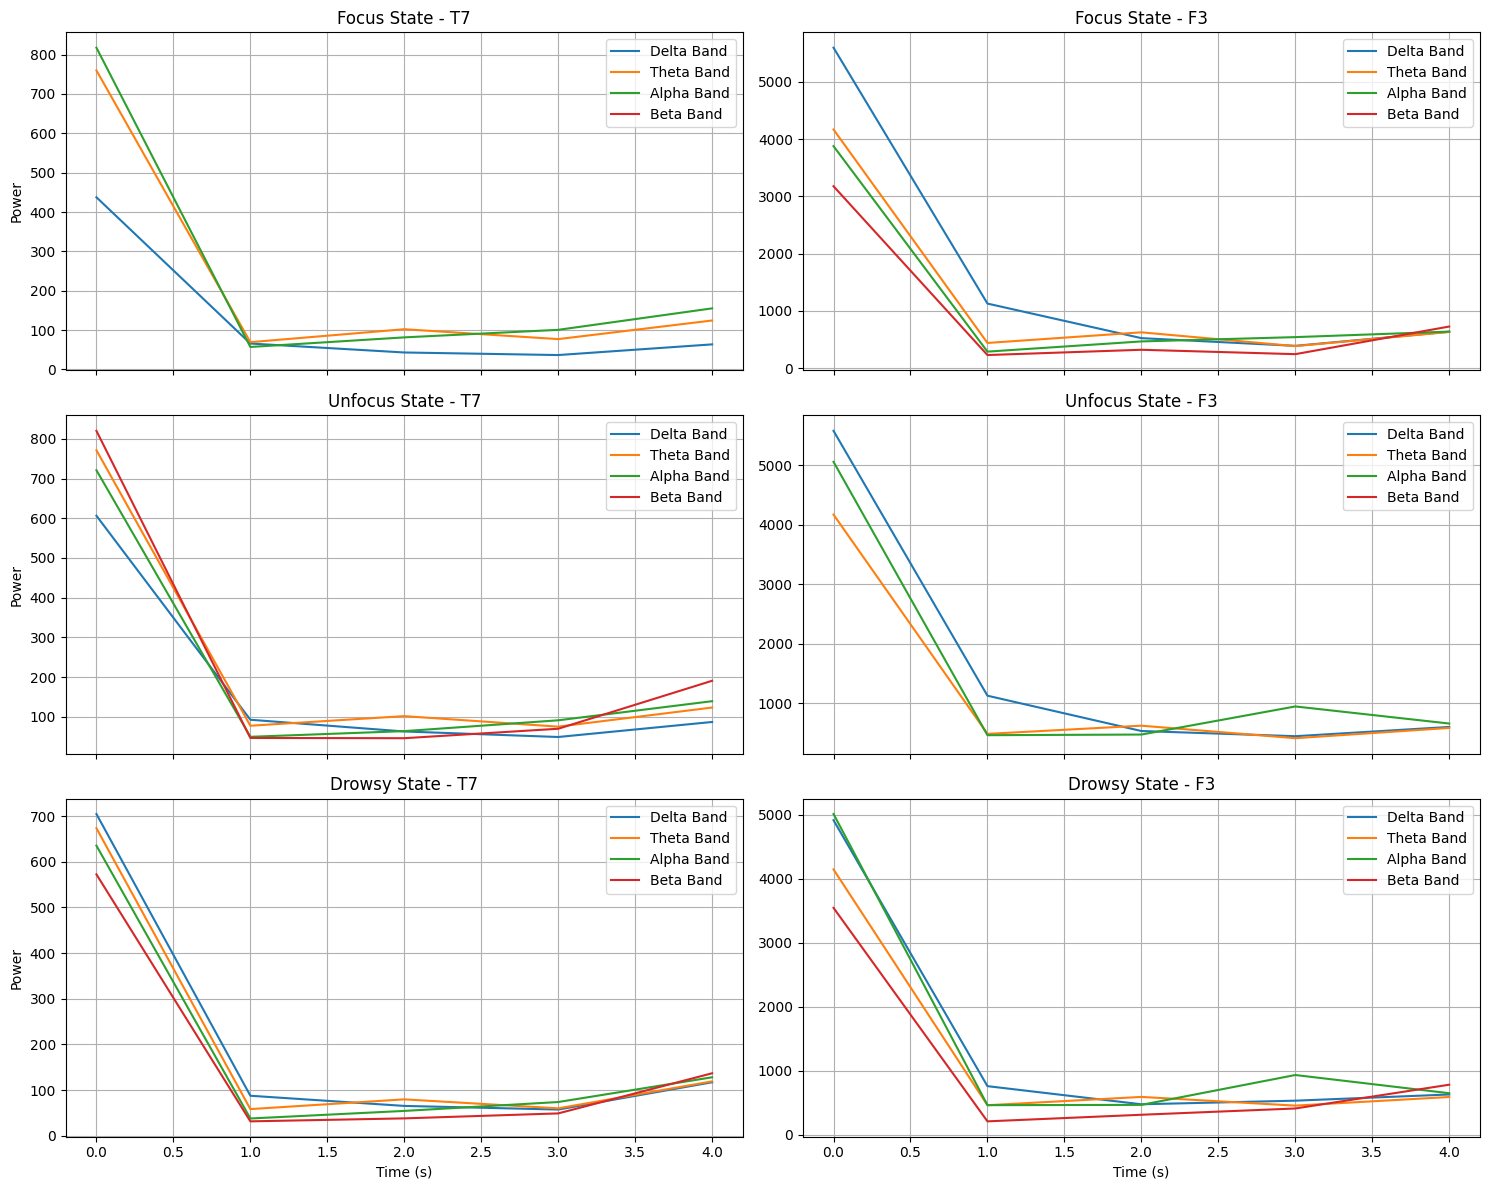

In [ ]:
# Hàm tính công suất theo dải tần số
def compute_band_powers(power_spectrogram, freq_bands):
    band_powers = {band: [] for band in freq_bands}
    for band, (low, high) in freq_bands.items():
        idx = np.where((power_spectrogram[:, 0] >= low) & (power_spectrogram[:, 0] <= high))[0]
        band_powers[band] = power_spectrogram[idx, 1:].mean(axis=0)
    return band_powers

# Hàm vẽ đồ thị so sánh giữa hai kênh
def plot_band_power_comparison(channel_idx1, channel_idx2, subject, frequency_features, freq_bands):
    """
    So sánh công suất của các dải tần số giữa hai kênh EEG trên ba trạng thái (focus, unfocus, drowsing).

    Parameters:
    - channel_idx1, channel_idx2: int, chỉ số của hai kênh EEG cần so sánh.
    - subject: str, tên subject.
    - frequency_features: dict, dữ liệu đặc trưng tần số của các trạng thái.
    - freq_bands: dict, các dải tần số (band) và giới hạn tương ứng.
    """
    states = ['focus', 'unfocus', 'drowsy']

    # Tính công suất theo dải tần số cho từng trạng thái và kênh
    band_powers1 = {state: compute_band_powers(frequency_features[state][subject][channel_idx1], freq_bands) for state in states}
    band_powers2 = {state: compute_band_powers(frequency_features[state][subject][channel_idx2], freq_bands) for state in states}

    # Tạo lưới 3x2: 3 trạng thái x 2 kênh
    fig, axs = plt.subplots(3, 2, figsize=(15, 12), sharex=True)

    channel1_name = channel_names[channel_idx1]
    channel2_name = channel_names[channel_idx2]

    for i, state in enumerate(states):
        band_powers1_state = band_powers1[state]
        band_powers2_state = band_powers2[state]

        # channel 1
        for band, power in band_powers1_state.items():
            axs[i, 0].plot(power, label=f'{band} Band')
        axs[i, 0].legend()
        axs[i, 0].set_title(f'{state.capitalize()} State - {channel1_name}')
        axs[i, 0].set_ylabel('Power')
        axs[i, 0].grid()

        # channel 2
        for band, power in band_powers2_state.items():
            axs[i, 1].plot(power, label=f'{band} Band')
        axs[i, 1].legend()
        axs[i, 1].set_title(f'{state.capitalize()} State - {channel2_name}')
        axs[i, 1].grid()

    axs[-1, 0].set_xlabel('Time (s)')
    axs[-1, 1].set_xlabel('Time (s)')

    plt.tight_layout()
    plt.show()

# Sử dụng hàm
freq_bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30)}
channel1_idx = 4  
channel2_idx = 2
subject = 'Subject_1'

plot_band_power_comparison(
    channel_idx1=channel1_idx,
    channel_idx2=channel2_idx,
    subject=subject,
    frequency_features=frequency_features,
    freq_bands=freq_bands
)


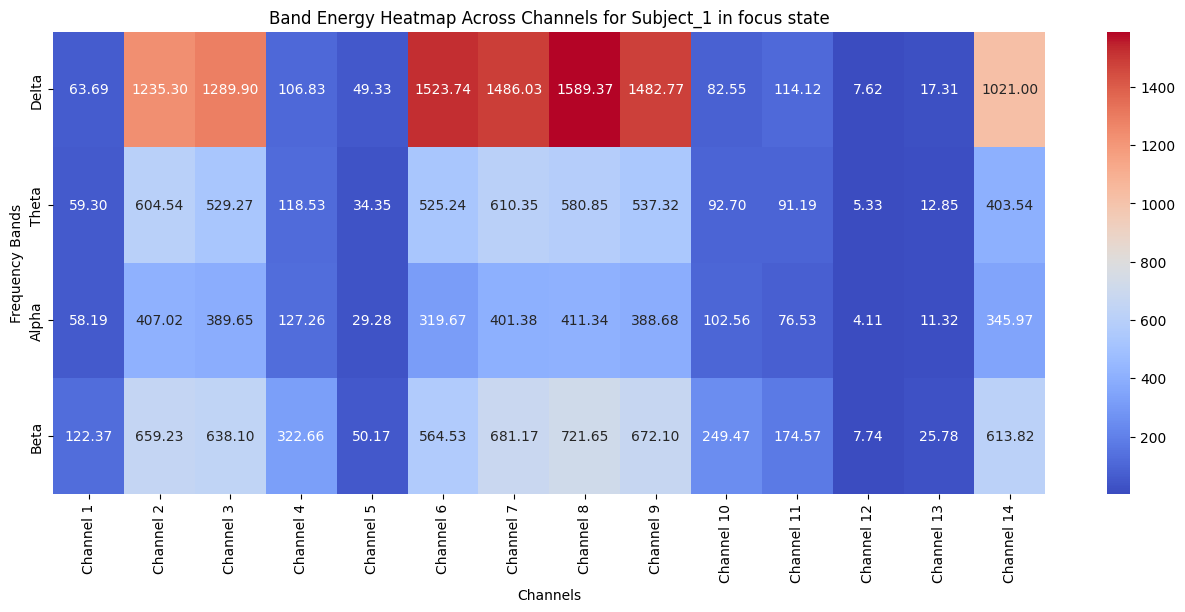

In [ ]:
import seaborn as sns

def plot_energy_heatmap(frequency_features, state, subject):
    energy_labels = ["Delta", "Theta", "Alpha", "Beta"]
    features = frequency_features[state][subject]
    band_energy = features[:, :, [2, 3, 4, 5]].mean(axis=1)  # Delta, Theta, Alpha, Beta
    plt.figure(figsize=(16, 6))
    sns.heatmap(band_energy.T, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=[f"Channel {i+1}" for i in range(features.shape[0])], yticklabels=energy_labels)
    plt.title(f"Band Energy Heatmap Across Channels for {subject} in {state} state")
    plt.xlabel("Channels")
    plt.ylabel("Frequency Bands")
    plt.show()

# Vẽ heatmap năng lượng cho Subject_1 trong trạng thái 'focus'
plot_energy_heatmap(frequency_features, state='focus', subject='Subject_1')


In [490]:
# gộp các bin dữ liệu trong khoảng 0.5Hz và lấy trong khoảng 0-18Hz
num = []

power_focus_bin = {}
for name in trail_names:
    power_focus_bin[name] = np.zeros([7,36,601])
    
power_unfocus_bin = {}
for name in trail_names:
    power_unfocus_bin[name] = np.zeros([7,36,601])
    
power_drowsy_bin = {}
for name in trail_names:
    power_drowsy_bin[name] = np.zeros([7,36,601])

for name in trail_names:
    for chn in range(col):
        j=0
        for i in range(1,144,4):
            power_focus_bin[name][chn,j,:] = np.average(power_focus[name][chn,i:i+4,:],axis=0)
            power_unfocus_bin[name][chn,j,:] = np.average(power_unfocus[name][chn,i:i+4,:],axis=0)
            power_drowsy_bin[name][chn,j,:] = np.average(power_drowsy[name][chn,i:i+4,:],axis=0)
            j=j+1
            

In [ ]:
# avarage over 15 seconds running window.
power_focus_ave = {}
for name in trail_names:
    power_focus_ave[name] = np.zeros([7,36,585])
    
power_unfocus_ave = {}
for name in trail_names:
    power_unfocus_ave[name] = np.zeros([7,36,585])
    
power_drowsy_ave = {}
for name in trail_names:
    power_drowsy_ave[name] = np.zeros([7,36,585])

for name in trail_names:
    for chn in range(col):
        j=0
        for k in range(0,585):
            power_focus_ave[name][chn,:,j] = np.average(power_focus_bin[name][chn,:,k:k+15],axis=1)
            power_unfocus_ave[name][chn,:,j] = np.average(power_unfocus_bin[name][chn,:,k:k+15],axis=1)
            power_drowsy_ave[name][chn,:,j] = np.average(power_drowsy_bin[name][chn,:,k:k+15],axis=1)
            j=j+1

In [560]:
power_focus_ave['eeg_record11'].shape

(7, 36, 598)

In [496]:
# Turn the data into a vector 

focus_features = {}
for name in trail_names:
    focus_features[name] = np.zeros([252,300])
    
unfocus_features = {}
for name in trail_names:
    unfocus_features[name] = np.zeros([252,300])
    
drowsy_features = {}
for name in trail_names:
    drowsy_features[name] = np.zeros([252,300])

for name in trail_names:
    for j in range(300):      
        focus_features[name][:,j] = power_focus_ave[name][:,:,j].reshape(1,-1)
        unfocus_features[name][:,j] = power_unfocus_ave[name][:,:,j].reshape(1,-1)
        drowsy_features[name][:,j] = power_drowsy_ave[name][:,:,j].reshape(1,-1)
    focus_features[name] = 10*np.log(focus_features[name])
    unfocus_features[name] = 10*np.log(unfocus_features[name])
    drowsy_features[name] = 10*np.log(drowsy_features[name])

In [498]:
focus_features['eeg_record10'].shape

(252, 300)

## 3. Label and Split Data

In [ ]:
# label 0
label_focus = [0] * 300
# label 1
label_unfocus = [1] * 300
# label 2
label_drowsy = [2] * 300

# subject is the variable for all paticipants
subj1_files={'eeg_record3','eeg_record4','eeg_record5','eeg_record6','eeg_record7'}
subj2_files={'eeg_record10','eeg_record11','eeg_record12','eeg_record13','eeg_record14'}
subj3_files={'eeg_record17','eeg_record18','eeg_record19','eeg_record20','eeg_record21'}
subj4_files={'eeg_record24','eeg_record25','eeg_record26','eeg_record27','eeg_record28'}
subj5_files={'eeg_record31','eeg_record32','eeg_record33','eeg_record34'}

In [497]:
target = []
size = focus_features['eeg_record10'].shape[0]
subj = np.array([]).reshape(size, 0).copy()

for name in trail_names:
    subj = np.concatenate((subj, focus_features[name]), axis=1)
    subj = np.concatenate((subj, unfocus_features[name]), axis=1)
    subj = np.concatenate((subj, drowsy_features[name]), axis=1)
    target = target + label_focus + label_unfocus + label_drowsy
subj = subj.T
target = np.array(target)

In [329]:
print('length of the target:',len(target))
print('the shape of the data from the subject:', subj.shape)

length of the target: 20700
the shape of the data from the subject: (20700, 280)


In [330]:
target1=[]
subj1 = np.array([]).reshape(size, 0).copy()
for name in subj1_files:
    subj1 = np.concatenate((subj1, combined_features['focus'][name]), axis=1)
    subj1 = np.concatenate((subj1,combined_features['unfocus'][name]), axis=1)
    subj1 = np.concatenate((subj1, combined_features['drowsy'][name]), axis=1)  
    target1 = target1 + label_focus + label_unfocus + label_drowsy
subj1 = subj1.T
target1 = np.array(target1)

In [331]:
print('length of the target subj1:',len(target1))
print('the shape of the data from the subject1:', subj1.shape)

length of the target subj1: 4500
the shape of the data from the subject1: (4500, 280)


In [332]:
target2 = []
subj2 = np.array([]).reshape(280, 0).copy()
for name in subj2_files:
    subj2 = np.concatenate((subj2, combined_features['focus'][name]), axis=1)
    subj2 = np.concatenate((subj2, combined_features['unfocus'][name]), axis=1)
    subj2 = np.concatenate((subj2, combined_features['drowsy'][name]), axis=1) 
    target2 = target2 + label_focus + label_unfocus + label_drowsy
subj2 = subj2.T
target2 = np.array(target2)

In [333]:
target3 = []
subj3 = np.array([]).reshape(280, 0).copy()
for name in subj3_files:
    subj3 = np.concatenate((subj3, combined_features['focus'][name]), axis=1)
    subj3 = np.concatenate((subj3, combined_features['unfocus'][name]), axis=1)
    subj3 = np.concatenate((subj3, combined_features['drowsy'][name]), axis=1)  
    target3 = target3 + label_focus + label_unfocus + label_drowsy
subj3 = subj3.T
target3 = np.array(target3)

In [334]:
target4 = []
subj4 = np.array([]).reshape(280,0).copy()
for name in subj4_files:
    subj4 = np.concatenate((subj4, combined_features['focus'][name]), axis=1)
    subj4 = np.concatenate((subj4, combined_features['unfocus'][name]), axis=1)
    subj4 = np.concatenate((subj4, combined_features['drowsy'][name]), axis=1) 
    target4 = target4 + label_focus + label_unfocus + label_drowsy
subj4 = subj4.T
target4 = np.array(target4)

In [335]:
target5 = []
subj5 = np.array([]).reshape(280,0).copy()
for name in subj5_files:
    subj5 = np.concatenate((subj5, combined_features['focus'][name]), axis=1)
    subj5 = np.concatenate((subj5, combined_features['unfocus'][name]), axis=1)
    subj5 = np.concatenate((subj5, combined_features['drowsy'][name]), axis=1) 
    target5 = target5 + label_focus + label_unfocus + label_drowsy
subj5 = subj5.T
target5 = np.array(target5)

In [336]:
subj1.shape

(4500, 280)

In [337]:
# thực hiện chuyển đổi dữ liệu 
new_subj = []
n_past = 8

for i in range(n_past, len(subj1)):
    flattened_sample = subj1[i-n_past:i, :size].flatten()[:size] 
    new_subj.append(flattened_sample)

new_subj = np.array(new_subj)
new_target = target1[n_past:]


In [338]:
new_subj.shape

(4492, 280)

In [ ]:
# train data from subj1
def split_and_scale(data, target, train_ratio=0.8, validation_ratio=0.1, random_state=42):
    """
    Chia dữ liệu thành tập train, validation, test và chuẩn hóa theo tỷ lệ cho trước.
    
    Parameters:
    - data (ndarray): Dữ liệu đầu vào (num_samples, num_features).
    - target (ndarray): Nhãn tương ứng (num_samples,).
    - train_ratio (float): Tỷ lệ tập train (mặc định 80%).
    - validation_ratio (float): Tỷ lệ tập validation (mặc định 10%).
    - random_state (int, optional): Giá trị random seed để tái tạo kết quả.
    
    Returns:
    - data_train_scaled (ndarray): Tập dữ liệu train đã chuẩn hóa.
    - data_validation_scaled (ndarray): Tập dữ liệu validation đã chuẩn hóa.
    - data_test_scaled (ndarray): Tập dữ liệu test đã chuẩn hóa.
    - data_train_target (ndarray): Nhãn cho tập train.
    - data_validation_target (ndarray): Nhãn cho tập validation.
    - data_test_target (ndarray): Nhãn cho tập test.
    """
    if random_state is not None:
        np.random.seed(random_state)

    num_samples = data.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    train_size = int(train_ratio * num_samples)
    validation_size = int(validation_ratio * num_samples)
    
    # Chia dữ liệu và nhãn
    data_train = data[indices[:train_size]]
    data_validation = data[indices[train_size:train_size + validation_size]]
    data_test = data[indices[train_size + validation_size:]]
    
    data_train_target = target[indices[:train_size]]
    data_validation_target = target[indices[train_size:train_size + validation_size]]
    data_test_target = target[indices[train_size + validation_size:]]

    data_train_reshaped = data_train.reshape(data_train.shape[0], -1)
    data_validation_reshaped = data_validation.reshape(data_validation.shape[0], -1)
    data_test_reshaped = data_test.reshape(data_test.shape[0], -1)
    
    scaler = preprocessing.StandardScaler().fit(data_train_reshaped)
    data_train_scaled = scaler.transform(data_train_reshaped)
    data_validation_scaled = scaler.transform(data_validation_reshaped)
    data_test_scaled = scaler.transform(data_test_reshaped)
    
    return (data_train_scaled, data_validation_scaled, data_test_scaled,
            data_train_target, data_validation_target, data_test_target)



In [340]:
result = split_and_scale(new_subj, new_target)
data_train_scaled, data_validation_scaled, data_test_scaled, data_train_target, data_validation_target, data_test_target = result

## Model Development

#### Thử nghiệm với model SVM kernel = RBF

In [341]:
svm = SVC(kernel='rbf')
svm.fit(data_train_scaled, data_train_target)
print(f"Score for Training data with SVM model for subject1:", np.round(svm.score(data_train_scaled, data_train_target), 4))
print(f"Score for Testing data with SVM mode for subject1", np.round(svm.score(data_test_scaled, data_test_target), 4))

Score for Training data with SVM model for subject1: 0.9802
Score for Testing data with SVM mode for subject1 0.98


In [ ]:

onehot = OneHotEncoder()
data_train_target1 = onehot.fit_transform(data_train_target.reshape(-1, 1))
data_test_target1 = onehot.transform(data_test_target.reshape(-1, 1))
data_validation_target1 = onehot.transform(data_validation_target.reshape(-1, 1))

In [343]:
data_train_target1 = data_train_target1.toarray()
data_test_target1 = data_test_target1.toarray()
data_validation_target1 = data_validation_target1.toarray()

#### Thử nghiệm với CNN

In [344]:
arr = np.arange(new_subj.shape[0])
np.random.shuffle(arr)
data_train, data_test = new_subj[arr[:int(0.8 * new_subj.shape[0])]], new_subj[arr[int(0.8 * new_subj.shape[0]):]]
data_train_target, data_test_target = new_target[arr[:int(0.8 * new_subj.shape[0])]], new_target[arr[int(0.8 * new_subj.shape[0]):]]

In [346]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device=torch.device(device_name)
print(f"Device: {device}")

Device: cuda


In [543]:
fs = 128
channels = 14
num_input = 1
num_class = 3
signal_length = 128

F1 = 8
D = 3
F2 = D*F1

In [544]:
kernel_size_1= (1,round(fs/2)) 
kernel_size_2= (channels, 1)
kernel_size_3= (1, round(fs/8))
kernel_size_4= (1, 1)

kernel_avgpool_1= (1,4)
kernel_avgpool_2= (1,8)
dropout_rate= 0.2

ks0= int(round((kernel_size_1[0]-1)/2))
ks1= int(round((kernel_size_1[1]-1)/2))
kernel_padding_1= (ks0, ks1-1)
ks0= int(round((kernel_size_3[0]-1)/2))
ks1= int(round((kernel_size_3[1]-1)/2))
kernel_padding_3= (ks0, ks1)

In [545]:
class EEGNet(nn.Module): 
    def __init__(self):
        super().__init__()
        # layer 1
        self.conv2d = nn.Conv2d(num_input, F1, kernel_size_1, padding=kernel_padding_1)
        self.Batch_normalization_1 = nn.BatchNorm2d(F1)
        # layer 2
        self.Depthwise_conv2D = nn.Conv2d(F1, D*F1, kernel_size_2, groups= F1)
        self.Batch_normalization_2 = nn.BatchNorm2d(D*F1)
        self.Elu = nn.ELU()
        self.Average_pooling2D_1 = nn.AvgPool2d(kernel_avgpool_1)
        self.Dropout = nn.Dropout2d(dropout_rate)
        # layer 3
        self.Separable_conv2D_depth = nn.Conv2d( D*F1, D*F1, kernel_size_3,
                                                padding=kernel_padding_3, groups= D*F1)
        self.Separable_conv2D_point = nn.Conv2d(D*F1, F2, kernel_size_4)
        self.Batch_normalization_3 = nn.BatchNorm2d(F2)
        self.Average_pooling2D_2 = nn.AvgPool2d(kernel_avgpool_2)
        # layer 4
        self.Flatten = nn.Flatten()
        self.Dense = nn.Linear(F2*round(signal_length/32), num_class)
        self.Softmax = nn.Softmax(dim= 1)

    def forward(self, x):
        # layer 1
        y = self.Batch_normalization_1(self.conv2d(x))
        # layer 2
        y = self.Batch_normalization_2(self.Depthwise_conv2D(y))
        y = self.Elu(y)
        y = self.Dropout(self.Average_pooling2D_1(y))
        # layer 3
        y = self.Separable_conv2D_depth(y)
        y = self.Batch_normalization_3(self.Separable_conv2D_point(y))
        y = self.Elu(y)
        y = self.Dropout(self.Average_pooling2D_2(y))
        # layer 4
        y = self.Flatten(y)
        y = self.Dense(y)
        y = self.Softmax(y)

        return y
model = EEGNet().to(device)

In [548]:
!pip install torchsummary -q

In [549]:

from torchsummary import summary

summary(model, (1, 14, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 14, 127]             520
       BatchNorm2d-2           [-1, 8, 14, 127]              16
            Conv2d-3           [-1, 24, 1, 127]             360
       BatchNorm2d-4           [-1, 24, 1, 127]              48
               ELU-5           [-1, 24, 1, 127]               0
         AvgPool2d-6            [-1, 24, 1, 31]               0
         Dropout2d-7            [-1, 24, 1, 31]               0
            Conv2d-8            [-1, 24, 1, 32]             408
            Conv2d-9            [-1, 24, 1, 32]             600
      BatchNorm2d-10            [-1, 24, 1, 32]              48
              ELU-11            [-1, 24, 1, 32]               0
        AvgPool2d-12             [-1, 24, 1, 4]               0
        Dropout2d-13             [-1, 24, 1, 4]               0
          Flatten-14                   

In [ ]:
train_batch_size = 256
dataset = TensorDataset(torch.tensor(data_train, dtype=torch.float32).unsqueeze(1), torch.tensor(data_train_target, dtype=torch.long))
train_loader = DataLoader(dataset, batch_size=train_batch_size, shuffle=True)


In [564]:
def train_one_epoch(model, train_loader, loss_fn, optimizer):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes= num_class).to(device)
    
    for i, (inputs, targets) in enumerate(data_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        optimizer.zero_grad()

        loss_train.update(loss.item())
        acc_train(outputs, targets.int())
        
    return model, loss_train.avg, acc_train.compute().item()

In [ ]:
num_epochs = 101
loss_fn= nn.CrossEntropyLoss().to(device)
optimizer= optim.NAdam(model.parameters(), lr= 0.01)

loss_train_hist = []
acc_train_hist = []

for epoch in range(num_epochs):
    model, loss_train, acc_train = train_one_epoch(model, 
                                                 data_loader, 
                                                 loss_fn, 
                                                 optimizer)
  
    loss_train_hist.append(loss_train)
    acc_train_hist.append(acc_train)

    if (epoch%10== 5)or(epoch%10== 0): 
        print(f'epoch {epoch}:')
        print(f' Loss= {loss_train:.4}, Accuracy= {int(acc_train*100)}% \n')

In [ ]:
plt.plot(range(num_epochs), acc_train_hist, 'b-', label='Train')
plt.plot(range(num_epochs), acc_validation_hist, 'r-', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()